In [2]:
# importing the libraries
import numpy as np
import peakutils
#import syntheticdata


from peakutils.plot import plot as pplot
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import interpolate

import pandas as pd

In [401]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def loaddata(tadata_filename):
    tadata = np.genfromtxt(tadata_filename, delimiter=',', skip_footer = 16)
    tadata_z = tadata[1:,1:]
    tadata_timedelay = tadata[0,1:]  #timedelay in ps
    tadata_timedelay = np.nan_to_num(tadata_timedelay)
    tadata_nm = tadata[1:,0]  #wavelength in nm
    tadata_nm = np.nan_to_num(tadata_nm)
    tadata_z_corr = np.empty((len(tadata_nm), len(tadata_timedelay)))
    tadata_z_corr = np.nan_to_num(tadata_z)
    
    return tadata, tadata_timedelay, tadata_nm, tadata_z_corr

def plot_peaks_lows_highs(x, highs, lows, algorithm=None, mph=None, mpd=None):
    """Plot results of the peak dectection."""
    
    _, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x, 'b', lw=1)
    if highs.size:
        label = 'high peak'
        label = label + 's' if highs.size > 1 else label
        ax.plot(highs, x[highs], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%d %s' % (highs.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    if lows.size:
        label = 'low peak'
        label = label + 's' if lows.size > 1 else label
        ax.plot(lows, x[lows], '+', mfc=None, mec='g', mew=2, ms=8,
                label='%d %s' % (lows.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    ax.set_xlim(-.02*x.size, x.size*1.02-1)
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
    ax.set_xlabel('Data #', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.set_title('%s (mph=%s, mpd=%s)' % (algorithm, mph, mpd))
    plt.show()
    
# load some data
def loaddata(data_filename):
    """load matrix data"""
    data = np.genfromtxt(data_filename, delimiter='\t')
    data_nm = data[1:,0]    #wavelength in nm
    data_time = data[0,1:]
    data_z = data[1:, 1:]

    return data_nm, data_time, data_z

# add noise
def add_noise(nm_array, y_array, noise_coefficient):
    # Add noise
    np.random.seed(1800)
    y_noise = noise_coefficient * np.random.normal(size=nm_array.size)
    y_proc = y_array + y_noise
    
    return y_proc

def earth_Smoothing(nm_array, y_array,noise_coefficient):        
        
    from pyearth import Earth
   # Fit an Earth model
    model = Earth(smooth=True)
    np.random.seed(42)
    ydata = y_array + noise_coefficient*np.random.normal(size=nm_array.size)
    model.fit(nm_array, ydata)

   # Print the model
    #print(model.trace())
    #print(model.summary())

   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)
    
    return  y_hat

def findpeak_low(data_z_array, threshold, min_dist):
    """find peaks and return indices of the peaks""" 
    data_z_arrayInverted = data_z_array * -1
    peak_indices = peakutils.indexes(data_z_arrayInverted, thres=threshold, min_dist=min_dist)
    
    return peak_indices


def findpeak(data_z_array, threshold, min_dist):
    """find peaks and return indices of the peaks""" 
    peak_indices = peakutils.indexes(data_z_array, thres=threshold, min_dist=min_dist)
    
    return peak_indices

def earth_smooth_matrix(nm_array,data_matrix,noise_coefficient):
    num_array = np.shape(data_matrix)[1]
    num_array1 = np.shape(data_matrix)[0]
    
    smooth_matx = pd.DataFrame(np.empty((num_array1,1)), columns = ['a'])
    noise_matx = pd.DataFrame(np.empty((num_array1,1)), columns = ['a'])
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        
        # get noise and smooth list
        noise_array = add_noise(nm_array, data_array, noise_coefficient).tolist()
        smooth_array =earth_Smoothing(nm_array,data_array,noise_coefficient).tolist()
        
        # get noise dataframe
        DF = pd.DataFrame(noise_array,columns = [i])
        noise_matx = noise_matx.join(DF)
        
        # get smooth dataframe
        df = pd.DataFrame(smooth_array,columns = [i])
        smooth_matx = smooth_matx.join(df)
    
    # drop the first columns
    noise_matx = noise_matx.drop(columns='a')
    smooth_matx = smooth_matx.drop(columns='a')

    return noise_matx, smooth_matx

def earth_high_peak_matrix(nm_array,data_matrix,noise_coefficient,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    
    true_peak = []
    smooth_peak = []
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        noise_array = add_noise(nm_array, data_array, noise_coefficient)
        smooth_array = earth_Smoothing(nm_array, data_array,noise_coefficient)
        
        indexes=findpeak(data_array, threshold, min_dist).tolist()
        true_peak.append(indexes)
        
        indexes1=findpeak(smooth_array, threshold, min_dist).tolist()
        smooth_peak.append(indexes1)
                
        # transfer to dataframe
        true_df=pd.DataFrame(true_peak)
        smooth_df=pd.DataFrame(smooth_peak).fillna(0)
    
    return true_df, smooth_df


def earth_low_peak_matrix(nm_array,data_matrix,noise_coefficient,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    
    true_peak = []
    smooth_peak = []
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        noise_array = add_noise(nm_array, data_array, noise_coefficient)
        smooth_array = earth_Smoothing(nm_array, data_array,noise_coefficient)
        
        indexes=findpeak_low(data_array, threshold, min_dist).tolist()
        true_peak.append(indexes)
        
        indexes1=findpeak_low(smooth_array, threshold, min_dist).tolist()
        smooth_peak.append(indexes1)
                
        # transfer to dataframe
        true_df=pd.DataFrame(true_peak)
        smooth_df=pd.DataFrame(smooth_peak).fillna(0)
    
    return true_df, smooth_df



In [267]:
def id_outliers_replacewith_interp(x_array, data, m, win_len):
    reshape_x_array = []
    reshape_data = []
    quotient_array = np.empty(len(data))
    remainder_array = np.empty(len(data))
    quotient_array[0] = 0
    remainder_array[0] = 0  
    #print divmod(len(data), win_len)   
    quotient_max = divmod(len(data), win_len)[0]
    print (quotient_max)
    #quotient_array_new = []
    data_idx = np.arange(0, len(data), 1)
    for i in range(1, len(data_idx)):
        
        quotient = divmod(data_idx[i], win_len)[0]
        quotient_array[i] = quotient
        remainder = divmod(data_idx[i], win_len)[1]
        remainder_array[i] = remainder
        
        if quotient != quotient_array[i-1]:
            newslice = data[i - win_len: i]
            newslice_x = x_array[i - win_len: i]
            #print newslice
            reshape_data.append(newslice)
            reshape_x_array.append(newslice_x)
    
        else:
            pass
    quotient_max_idx = np.where(quotient_array == quotient_max)
    #print quotient_max_idx
    reshape_data.append(data[quotient_max_idx[0]])
    reshape_x_array.append(x_array[quotient_max_idx[0]])
    #print reshape_data
    reshape_data_shape = np.shape(reshape_data)[0]
    #print reshape_data_shape
    def id_outliers_and_delete(d,x, m):
        d_mean = np.mean(d)  
        d_stdev = np.std(d)
        new_d = np.empty_like(d)    
        
        for i in range(len(d)):
            d_pt = d[i]
          
            if abs(d_pt - d_mean) > m * d_stdev and x[i] != x_array[0] and x[i] != x_array[len(x_array) - 1]:
                new_d[i] = 1
            else:
                new_d[i] = 0
    
        outlier_idx = np.nonzero(new_d)[0]
        d_delete = np.delete(d, outlier_idx)
        x_delete = np.delete(x, outlier_idx)
        
        #print data2[outlier_idx]
        return x_delete, d_delete
    
    new_x_array = []
    new_data = []
    for i in range(reshape_data_shape):
        new_data.append(id_outliers_and_delete(reshape_data[i],reshape_x_array[i], 1)[1])#(id_outliers_replacewith_mean(reshape_data[i], m))
        new_x_array.append(id_outliers_and_delete(reshape_data[i],reshape_x_array[i],1)[0])
    new_data_flat = np.concatenate(new_data[:-1]).ravel().tolist()#.flatten()
    new_x_array_flat = np.concatenate(new_x_array[:-1]).ravel().tolist()#.flatten()
    new_data_final = np.concatenate((new_data_flat, new_data[reshape_data_shape - 1]))
    new_x_array_final = np.concatenate((new_x_array_flat, new_x_array[reshape_data_shape - 1]))
    
    new_data_final_interp = np.interp(x_array, new_x_array_final, new_data_final)    
    return new_data_final_interp

In [255]:
noisez_matx, smooth_matx = earth_smooth_matrix(datanm,dataz_matx,0.1)

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [173]:
matx_filename = '20180418_twogaussian_spectralshfit.txt'
datanm, datatime, dataz_matx = loaddata(matx_filename)

In [259]:
true_low_df, smooth_low_df = earth_low_peak_matrix(datanm, dataz_matx, 0.1, 0, 150)

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [402]:
## get the peak position dataframe of true data set
true_high_df, smooth_high_df = earth_high_peak_matrix(datanm, dataz_matx, 0.1, 0, 150)

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


* high peak position changes

# High peak changes

* true peak

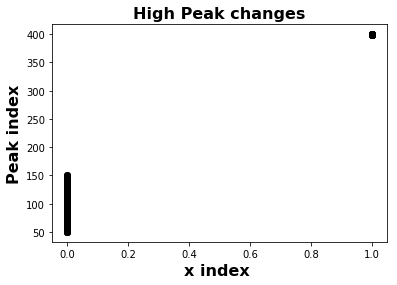

In [265]:
plt.figure()
for i in range(dataz_matx.shape[1]):
    plt.title('High Peak changes', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(true_high_df.iloc[i,:].values,'o', color='black')

* smooth peak

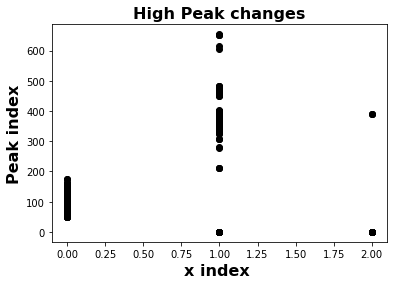

In [264]:
plt.figure()
for i in range(dataz_matx.shape[1]):
    plt.title('High Peak changes', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(smooth_high_df.iloc[i,:].values,'o', color='black')

In [346]:
smooth_high_df[0:5]

,0,1,2
0,50,402.0,0.0
1,54,394.0,0.0
2,54,394.0,0.0
3,54,394.0,0.0
4,54,394.0,0.0


* low peak position changes

# Low peak changes

* true peak

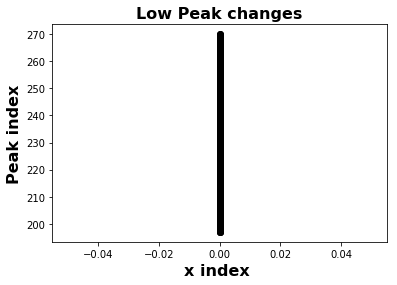

In [151]:
plt.figure()
for i in range(300):
    plt.title('Low Peak changes', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(true_low_df.iloc[i,:].values,'o', color='black')

* low peak

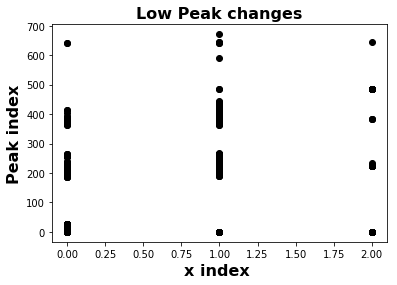

In [150]:
plt.figure()
for i in range(dataz_matx.shape[1]):
    plt.title('Low Peak changes', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(smooth_low_df.iloc[i,:].values,'o', color='black')

In [349]:
smooth_low_df[0:5]

,0,1,2
0,207.0,0.0,0.0
1,219.0,0.0,0.0
2,219.0,0.0,0.0
3,220.0,0.0,0.0
4,220.0,0.0,0.0


# Use peak correction to get a better peakset

In [266]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
from scipy.special import gamma
from sklearn.cluster import KMeans

* define new function called remover_outlier_peak

In [318]:
def remover_outlier_peak(datatime,true_high_df):
    outlier_df = pd.DataFrame(np.empty((500,1)), columns = ['a'])
    for i in range(true_high_df.shape[1]):
        peak_pos = np.array(true_high_df.iloc[:, i])
        outlier_interp = id_outliers_replacewith_interp(datatime, peak_pos, 1, 25)
        DF = pd.DataFrame(outlier_interp ,columns = [i])
        outlier_df = outlier_df.join(DF)
        
    outlier_df = outlier_df.drop(columns='a')
        
    return outlier_df

In [321]:
outlier_high_df = remover_outlier_peak(datatime,smooth_high_df)

20
20
20


/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [326]:
outlier_low_df = remover_outlier_peak(datatime,smooth_low_df)

20
20
20


/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tutu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Peak Optimize Visulization

* high peak

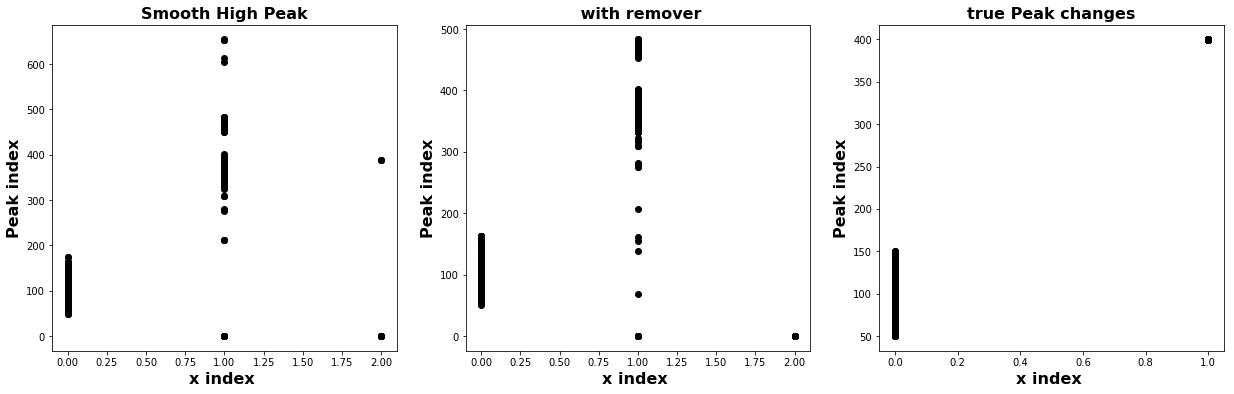

In [342]:
plt.figure(figsize=(21,6))
plt.subplot(132)
for i in range(dataz_matx.shape[1]):
    plt.title(' with remover', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(outlier_high_df.iloc[i,:].values,'o', color='black') 
    
plt.subplot(131)
for i in range(dataz_matx.shape[1]):
    plt.title('Smooth High Peak', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(smooth_high_df.iloc[i,:].values,'o', color='black')
      
plt.subplot(133)
for i in range(dataz_matx.shape[1]):
    plt.title('true Peak changes', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(true_high_df.iloc[i,:].values,'o', color='black')

* low peak

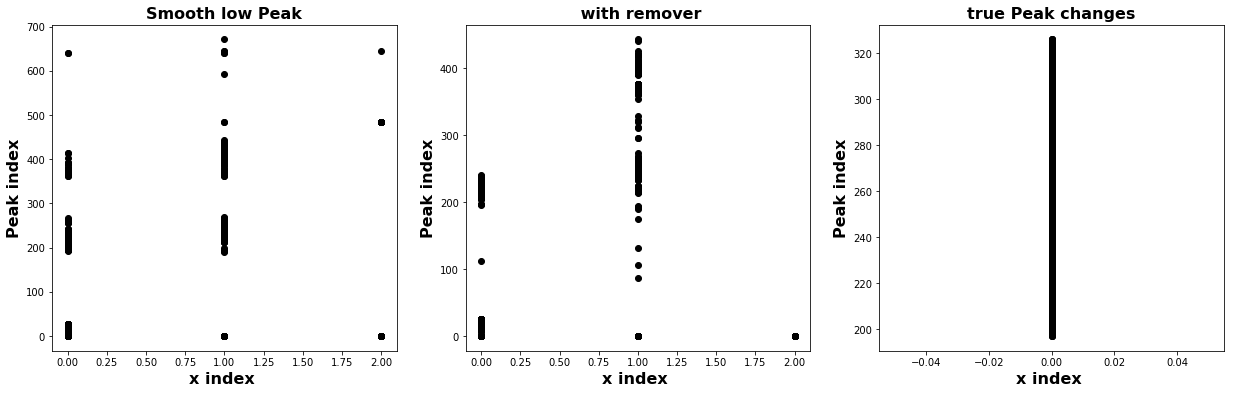

In [345]:
plt.figure(figsize=(21,6))
plt.subplot(132)
for i in range(dataz_matx.shape[1]):
    plt.title(' with remover', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(outlier_low_df.iloc[i,:].values,'o', color='black') 
    
plt.subplot(131)
for i in range(dataz_matx.shape[1]):
    plt.title('Smooth low Peak', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(smooth_low_df.iloc[i,:].values,'o', color='black')
      
plt.subplot(133)
for i in range(dataz_matx.shape[1]):
    plt.title('true Peak changes', fontsize = 16, fontweight = 'bold')
    plt.xlabel('x index ', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Peak index', fontsize = 16, fontweight = 'bold')
    plt.plot(true_low_df.iloc[i,:].values,'o', color='black')

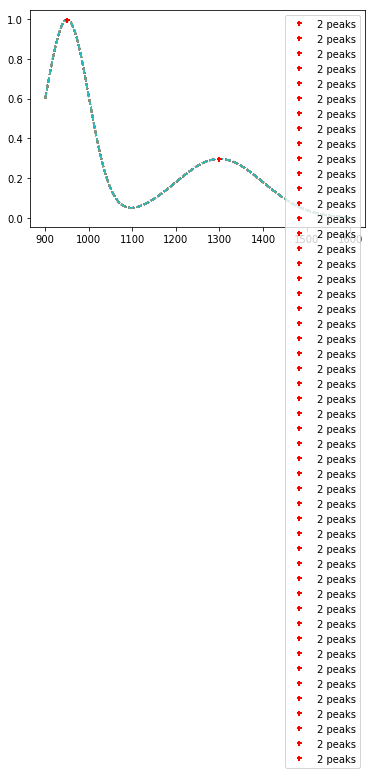

In [260]:
for i in range(50):
    pplot(datanm, dataz_matx[:,1], true_high_df.iloc[1,:].values.astype('int64'))   

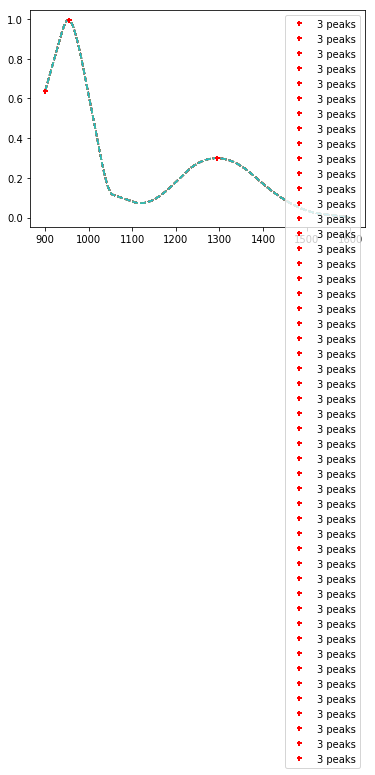

In [261]:
for i in range(50):
    pplot(datanm, smooth_matx.iloc[:, 1].values, smooth_high_df.iloc[1,:].values.astype('int64'))   